In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
np.random.seed(42)

In [2]:
charset = {
                'digit_0' : 0,
                'digit_1' : 1,
                'digit_2' : 2,
                'digit_3' : 3,
                'digit_4' : 4,
                'digit_5' : 5,
                'digit_6' : 6,
                'digit_7' : 7,
                'digit_8' : 8,
                'digit_9' : 9,
}
train_data = pd.read_csv('./dataset/train_digits_data.csv')
test_data  = pd.read_csv('./dataset/test_digits_data.csv')
X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1]
y_train = y_train.replace(charset)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = .2)

In [3]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
X_train = mm.fit_transform(X_train)
# X_dev   = mm.fit_transform(X_dev)
X_test = mm.fit_transform(X_test)

In [4]:
print("Data\t\t\t","Before Processing\t","After Processing")
print("=================================================================")
print("Training Set Images:\t" + str(train_data.shape)+"\t\t"+ str(X_train.shape))
print("Training Set Labels:\t" + str(train_data.iloc[:, -1].shape)+"\t\t"+ str(y_train.shape))
# print("Dev Set Images:\t\t" + str(X_dev.shape)+"\t\t"+ str(X_dev.shape))
# print("Dev Set Labels:\t\t" + str(y_dev.shape)+"\t\t\t"+ str(y_dev.shape))
print("Test Set Images:\t" + str(test_data.shape)+"\t\t"+ str(X_test.shape))
print("Test Set Labels:\t" + str(test_data.iloc[:, -1].shape)+"\t\t\t"+ str(test_data.iloc[:, -1].shape))
print("=================================================================")

Data			 Before Processing	 After Processing
Training Set Images:	(17000, 1025)		(13600, 1024)
Training Set Labels:	(17000,)		(13600,)
Test Set Images:	(3000, 1025)		(3400, 1024)
Test Set Labels:	(3000,)			(3000,)


In [5]:

class Classifier:
    def __init__(self, n_inputs, n_neurons = [32,32,10]):
        np.random.seed(42)
    # We have done here n_inputs/n_neurons instead of n_neurons/n_inputs to prevent the Transpose everytime
        self.weights1 = 0.01 * np.random.randn(n_inputs, n_neurons[0]) # The input shape and no of neurons you want to have in the layer
        self.biases1 =  0.01 * np.random.randn(1, n_neurons[0])
        self.weights2 = 0.01 *np.random.randn(n_neurons[0], n_neurons[1]) # The input shape and no of neurons you want to have in the layer
        self.biases2 = 0.01 * np.random.randn(1, n_neurons[1])
        self.weights3 = 0.01 * np.random.randn(n_neurons[1], n_neurons[2])
        self.biases3 = 0.01 * np.random.randn(1, n_neurons[2])
        self.output1 = None
        self.output2 = None
        self.output3 = None
        self.X = None
        self.y = None
        # activatied outputs
        self.output1_act = None
        self.output2_act = None
        self.output3_act = None
    def forward(self, inputs, weights, biases):
        """ The dot product of the input - weights - Biases (y = Wx + b) """
        output = np.dot(inputs, weights) + biases
        if(np.isnan(np.sum(output))):
            raise Exception("NaN values present in FW pass")
        elif(np.isinf(np.sum(output))):
            raise Exception("INF values present in FW Pass")
        
        return output

    def ReLU(self, inputs):
        """ Rectified Linear Activation Function """
        output = np.maximum(0, inputs)
        return output
    
    def Softmax(self, inputs):
    # subtract largest value to prevent overflow
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        if(np.isnan(np.sum(probabilities))):
            raise Exception("NaN values present in Softmax For")
        elif(np.isinf(np.sum(probabilities))):
            raise Exception("INF values present in Softmax For")
        
        return probabilities
        
    def categorical_cross_entropy(self,y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-6, 1-1e-6)
        # Handling if labels are 1D 
        correct_confidences = None
        if len(y_true.shape) == 1:
#             print(y_pred_clipped[range(samples), :].shape)
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) ==2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis =1)
        else:
            raise Exception("Sorry, no numbers below zero")
        
        negative_log_likelihoods = -np.log(correct_confidences)
#         print(negative_log_likelihoods.shape)
        return negative_log_likelihoods 
    
    def linear_backward(self,inputs, weights, dvalues):
        self.dweights_linear = np.dot(inputs.T, dvalues)
        self.dbiases_linear = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinput_linear = np.dot(dvalues, weights.T)
        
        if(np.isnan(np.sum(self.dweights_linear))):
            raise Exception("NaN values present in Linear Back")
        elif(np.isinf(np.sum(self.dweights_linear))):
            raise Exception("INF values present in Linear BAck")
        
        
        return self.dweights_linear, self.dinput_linear
    
    def linear_backward_with_l2(self,inputs, weights, dvalues, lambd = 0.5):
        """  """
        m = inputs.shape[1]
        self.dweights_linear = np.dot(inputs.T, dvalues) + (lambd*weights)/m
        self.dbiases_linear = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinput_linear = np.dot(dvalues, weights.T) 
        
        if(np.isnan(np.sum(self.dweights_linear))):
            raise Exception("NaN values present in Linear Back")
        elif(np.isinf(np.sum(self.dweights_linear))):
            raise Exception("INF values present in Linear BAck")
        
        
        return self.dweights_linear, self.dinput_linear
    
    def softmax_backward(self,dA, Z):
        """Compute backward pass for softmax activation"""
        softmax_output = Softmax(Z) 
        return softmax_output * (1 - softmax_output) * dA

    def ReLU_backward(self,dA, Z):
        
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        if(np.isnan(np.sum(dZ))):
            raise Exception("NaN values present in RELU Back")
        elif(np.isinf(np.sum(dZ))):
            raise Exception("INF values present in RELU BAck")
        return dZ
        
    def categorical_cross_entropy_backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        labels = len(dvalues[0])
        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs_loss = self.dinputs / samples
        if(np.isnan(np.sum(self.dinputs))):
            raise Exception("NaN values present in Softmax Back")
        elif(np.isinf(np.sum(self.dinputs))):
            raise Exception("INF values present in Softmax_back")
        return self.dinputs
    
    def softmax_categorical_cross_entropy_combined_backward(self, dvalues, y_true):
        samples = len(dvalues)
        #handling Ohe values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs_combined = dvalues.copy()
        # Calculate gradient
        self.dinputs_combined[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs_combined = self.dinputs_combined / samples
        if(np.isnan(np.sum(self.dinputs_combined))):
            raise Exception("NaN values present in Softmax Back")
        elif(np.isinf(np.sum(self.dinputs_combined))):
            raise Exception("INF values present in Softmax_back")
       
        return self.dinputs_combined
        
    
    def compute_loss(self,y_pred, y_true):
        sample_losses = self.categorical_cross_entropy(y_pred, y_true)
        loss = np.mean(sample_losses)
        return loss
    
    def compute_loss_with_l2(self,y_pred, y_true, lambd = 0.5):
        m = 10
        sample_losses = self.categorical_cross_entropy(y_pred, y_true)
        L2_regularization_cost = (lambd/(2*m))*(np.sum(np.square(self.weights1) + np.sum(np.square(self.weights2) + np.sum(np.square(self.weights3)))))
        loss = np.mean(sample_losses) 
        return loss
    
    
    def forward_pass(self, X):
        self.X = X
        self.output1     = self.forward(self.X, self.weights1, self.biases1)
        self.output1_act = self.ReLU(self.output1)
        self.output2     = self.forward(self.output1_act, self.weights2, self.biases2)
        self.output2_act = self.ReLU(self.output2)
        self.output3     = self.forward(self.output2_act, self.weights3, self.biases3)
        self.output3_act = self.Softmax(self.output3)
#         print("Softmax SUM", np.sum(self.output3_act, axis = 1))
        if(np.isnan(np.sum(self.output3_act))):
            raise Exception("NaN values present in data")
        elif(np.isinf(np.sum(self.output3_act))):
            raise Exception("INF values present in data")
        
        
    def check_inf(self):
        check_weights = np.any(np.isinf(self.weights1)) or np.any(np.isinf(self.weights2)) or np.any(np.isinf(self.weights3))
        check_bias    = np.any(np.isinf(self.biases1)) or np.any(np.isinf(self.biases2)) or np.any(np.isinf(self.biases3))
        return (check_weights or check_bias)
    
    def backward_pass(self, y, learning_rate= 0.1, iteration = 10000):
        self.y = y
        for i in range(iteration):
            self.forward_pass(self.X)
            predictions = np.argmax(self.output3_act, axis=1)
            
            
            gradient_output3_act                  = self.softmax_categorical_cross_entropy_combined_backward(self.output3_act, self.y)
            gradient_output3, gradient_input3     = self.linear_backward(self.output2,self.weights3,gradient_output3_act)
            gradient_output2_act                  = self.ReLU_backward(gradient_input3, self.output2)
            gradient_output2, gradient_input2     = self.linear_backward(self.output1, self.weights2, gradient_output2_act)
            gradient_output1_act                  = self.ReLU_backward(gradient_input2, self.output1)
            gradient_output1, gradient_input1     = self.linear_backward(self.X, self.weights1, gradient_output1_act)
            
            self.weights3  = self.weights3 - learning_rate * gradient_output3
            self.weights2  = self.weights2 - learning_rate * gradient_output2
            self.weights1  = self.weights1 - learning_rate * gradient_output1
            assert np.sum(gradient_output1) != np.nan, "The gradient has nan"
            assert np.sum(gradient_output1) != np.inf, "The gradient has inf"
            if i%100 == 0:

                loss = self.compute_loss(self.output3_act, y)
                self.accuracy = np.mean(predictions==self.y)
                if(self.accuracy > 99.0):
                    break
                print(f'Loss after a iteration {i}:{loss} || Accuracy: {self.accuracy * 100}')
                
    def backward_pass_with_l2(self, y, learning_rate= 0.1, iteration = 10000):
        self.y = y
        self.loss_list = []
        self.acc_list = []
        for i in range(iteration):
            self.forward_pass(self.X)
            predictions = np.argmax(self.output3_act, axis=1)
            
            
            gradient_output3_act                  = self.softmax_categorical_cross_entropy_combined_backward(self.output3_act, self.y)
            gradient_output3, gradient_input3     = self.linear_backward_with_l2(self.output2,self.weights3,gradient_output3_act)
            gradient_output2_act                  = self.ReLU_backward(gradient_input3, self.output2)
            gradient_output2, gradient_input2     = self.linear_backward_with_l2(self.output1, self.weights2, gradient_output2_act)
            gradient_output1_act                  = self.ReLU_backward(gradient_input2, self.output1)
            gradient_output1, gradient_input1     = self.linear_backward_with_l2(self.X, self.weights1, gradient_output1_act)
            
            self.weights3  = self.weights3 - learning_rate * gradient_output3
            self.weights2  = self.weights2 - learning_rate * gradient_output2
            self.weights1  = self.weights1 - learning_rate * gradient_output1
            assert np.sum(gradient_output1) != np.nan, "The gradient has nan"
            assert np.sum(gradient_output1) != np.inf, "The gradient has inf"
            loss = self.compute_loss_with_l2(self.output3_act, y)
            self.accuracy = np.mean(predictions==self.y)
            if i%100 == 0:
                self.loss_list.append(loss)
                self.acc_list.append(self.accuracy)
                if(self.accuracy > .99):
                    break
                print(f'Loss after a iteration {i}:{loss} || Accuracy: {self.accuracy * 100}')
        plt.plot(self.loss_list)
        plt.title("Training loss of the model")
    def load_model(self, weights, biases):
        self.weights1 = weights['1']
        self.weights2 = weights['2']
        self.weights3 = weights['3']
        
        self.biases1 = weights['b1']
        self.biases2 = weights['b2']
        self.biases3 = weights['b3']
    
    def save_model(self, filename = f'model.pkl'):
        from datetime import date

        today = date.today()

        filename = f'model_{self.accuracy}-{today}.pkl'
        weights = {
                    '1': self.weights1, '2': self.weights2, '3': self.weights3, 
                    'b1':self.biases1,'b2':self.biases2,'b3':self.biases3
        }
        pickle.dump(weights, open(filename, 'wb'))
        

    def predict(self, X_test):
        output1     = self.forward(X_test, self.weights1, self.biases1)
        output1_act = self.ReLU(output1)
        output2     = self.forward(output1_act, self.weights2, self.biases2)
        output2_act = self.ReLU(output2)
        output3     = self.forward(output2_act, self.weights3, self.biases3)
        output3_act = self.Softmax(output3)
        prediction, prediction_prob = np.argmax(output3_act, axis=1), np.max(output3_act, axis=1)
        return prediction, output3_act


Loss after a iteration 0:2.302677164824908 || Accuracy: 9.88970588235294
Loss after a iteration 100:2.302515542595861 || Accuracy: 9.88970588235294
Loss after a iteration 200:2.3022127735814624 || Accuracy: 9.88970588235294
Loss after a iteration 300:2.300683098220567 || Accuracy: 9.88970588235294
Loss after a iteration 400:2.182657292285168 || Accuracy: 21.97794117647059
Loss after a iteration 500:1.4683099749842623 || Accuracy: 39.38970588235294
Loss after a iteration 600:0.8797050229800318 || Accuracy: 69.33088235294119
Loss after a iteration 700:0.6028793855155222 || Accuracy: 78.03676470588236
Loss after a iteration 800:0.5310540704291291 || Accuracy: 80.11029411764706
Loss after a iteration 900:0.4879849582026894 || Accuracy: 82.27205882352942
Loss after a iteration 1000:0.44330377050061814 || Accuracy: 84.18382352941177
Loss after a iteration 1100:0.3811342484782405 || Accuracy: 87.55147058823529
Loss after a iteration 1200:0.34351750182304064 || Accuracy: 89.61764705882352
Loss

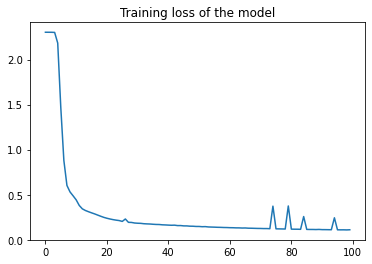

In [7]:
model  = Classifier(1024, [32,32, 10])
model.forward_pass(X_train)
loss = model.compute_loss_with_l2(model.output3_act, y_train)
model.backward_pass_with_l2(y_train)


In [10]:
model.save_model()

In [31]:
pr = model.predict(X_test)
pr[0][]

array([4.81698997e-05, 8.86685926e-04, 8.97632376e-04, 7.71747669e-01,
       9.59224063e-04, 1.45842385e-02, 1.69192944e-01, 1.33229704e-02,
       2.67895055e-06, 2.83577872e-02])

In [29]:
pr_1[0][3]

IndexError: invalid index to scalar variable.

10941    6
5250     3
10292    6
2266     1
6398     3
        ..
4706     2
8404     4
11114    6
7877     4
6188     3
Name: character, Length: 3400, dtype: int64

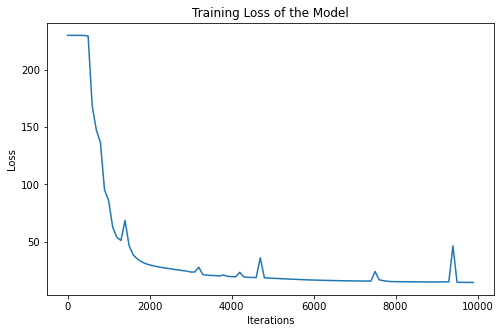

In [48]:
indexs = np.arange(0, 100) * 100
value = [x * 100 for x in model.loss_list]
plt.figure(figsize = (8,5))
plt.title("Training Loss of the Model")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(indexs,value)
plt.show()

In [29]:
# model  = Classifier(1024, [32,16, 10])
# model.forward_pass(X_train)
# loss = model.compute_loss_with_l2(model.output3_act, y_train)
# model.backward_pass(y_train)


In [42]:
model  = Classifier(1024, [32,32, 10])
model.forward_pass(X_train)
loss = model.compute_loss_with_l2(model.output3_act, y_train)
model.backward_pass_with_l2(y_train, iteration = 6000)

Loss after a iteration 0:2.302677164824908 || Accuracy: 9.88970588235294
Loss after a iteration 100:2.3025389759383508 || Accuracy: 9.88970588235294
Loss after a iteration 200:2.302351830029192 || Accuracy: 9.88970588235294
Loss after a iteration 300:2.3017235407476075 || Accuracy: 9.88970588235294
Loss after a iteration 400:2.2929413144350352 || Accuracy: 21.404411764705884
Loss after a iteration 500:1.6143845966005945 || Accuracy: 29.772058823529413
Loss after a iteration 600:1.423897904104247 || Accuracy: 41.61764705882353
Loss after a iteration 700:0.8854916359191214 || Accuracy: 66.31617647058825
Loss after a iteration 800:0.6372958570952105 || Accuracy: 76.52941176470588
Loss after a iteration 900:0.5454960065193428 || Accuracy: 79.02941176470588
Loss after a iteration 1000:0.5032702979940298 || Accuracy: 80.83088235294117
Loss after a iteration 1100:0.47472469876328915 || Accuracy: 83.41911764705883
Loss after a iteration 1200:0.43057262951013375 || Accuracy: 86.66176470588235
L

In [43]:
# saving the model
model.save_model(f'model.pkl')

In [7]:
y_test_pred = model.predict(X_test)
y_acc = np.mean((y_test == y_test_pred))
print(f'Test Accuracy of the model: {y_acc * 100}')

Test Accuracy of the model: 88.17647058823529


In [8]:
y_test_pred

array([3, 3, 6, ..., 6, 4, 3])

In [10]:
weights = {'1': model.weights1, '2': model.weights2, '3': model.weights3, 
           'b1':model.biases1,'b2':model.biases1,'b3':model.biases1}

In [11]:
import pickle
filename = 'base_model_weights_88.pkl'
pickle.dump(weights, open(filename, 'wb'))

In [11]:
import pickle
filename = 'base_model_100.pkl'
pickle.dump(model, open(filename, 'wb'))

In [12]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X_test)
print(result)

[6 2 6 ... 6 4 3]


In [56]:
import PIL
from PIL import Image
# foo = Image.open('dataset/Test/digit_0/103277.png')  # My image is a 200x374 jpeg that is 102kb large
foo = Image.open('number-5.png')
foo= foo.convert('L')
foo = foo.resize((32,32))
# print(foo.size)  # (200, 374)
image = np.array(foo)

image = image.reshape(-1)
image.shape

(1024,)

In [57]:
data = Image.fromarray(image)
      
    # saving the final output 
    # as a PNG file
data.save('gfg_dummy_pic.png')

In [58]:
model.predict(image)

array([5])

In [ ]:
# from fastapi import FastAPI, File
# from fastapi.middleware.cors import CORSMiddleware
# from PIL import Image
# import io
# import pickle
# import numpy as np
# import pandas as pd
# import uvicorn
# # import Classifier

# app = FastAPI()
# origins = [
#     'http://localhost:8000',
# ]
# model = Classifier(1024, [32,32,10])
# filename = 'base_model.pkl'
# loaded_model = pickle.load(open(filename, 'rb'))
# # print(loaded_model.weights1)
# result = loaded_model.predict(X_test)

# @app.get("/")
# async def root():
#     return {"message": "Wrong Method"}

# @app.post("/image")
# async def upload(file: bytes = File(...)):
#     print(result)
#     image = Image.open(io.BytesIO(file))
# #     image.show()
#     image = np.array(image)
# #     image = image.resize((32, 32))
# #     image = image.reshape(-1,)
#     print(image.shape)
#     # result = model.predict(image)
#     print("The result is :", result)
#     return {"Upload Status": "Complete"}



# if __name__ == '__main__':
#     config = uvicorn.Config(app)
#     server = uvicorn.Server(config)
#     await server.serve()